In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np
from hkvpy import plotting
from pathlib import Path

%config InlineBackend.figure_format='retina'

import anduryl
from anduryl.io.settings import CalibrationMethod
from anduryl.core import crps
from anduryl.core import anderson_darling

from scipy.stats import cramervonmises, kstest

from math import gamma, e

In [2]:
def upper_incomplete_gamma(a, x, iterations):
    """
    Implementation for upper incomplete gamma.
    """
    val = 1.0
    for d in reversed(range(1, iterations)):
        val = d * 2 - 1 - a + x + (d * (a - d)) / val
    return ((x**a) * (e ** (-x))) / val


def chi2cdf(x, df, iterations=100):
    """
    Chi squared cdf function. This function can also be used from scipy,
    but to reduce the compilation size a seperate (slighty slower)
    implementation without scipy is written.
    """
    if x == 0.0:
        return 1.0
    else:
        return 1 - upper_incomplete_gamma(0.5 * df, 0.5 * x, iterations) / gamma(0.5 * df)


def ranks(values):
    return (np.argsort(np.argsort(values)) + 0.5) / len(values)


def sa_cooke(vals, quants):
    s = dict(zip(*np.unique(np.digitize(vals, quants), return_counts=True)))
    s = np.array([s[i] / len(vals) if i in s else 0 for i in range(len(quants) + 1)])
    p = np.diff(np.concatenate([[0], quants, [1]]))
    idx = s > 0.0
    MI = np.sum(s[idx] * np.log(s[idx] / p[idx]))
    c = 1 - chi2cdf(x=2 * len(vals) * MI, df=len(s) - 1)
    return c


sa_function = {
    CalibrationMethod.CRPS: lambda x: crps.crps_sa(x)[0],
    CalibrationMethod.Chi2: lambda x: sa_cooke(x, quants),
    CalibrationMethod.CVM: lambda x: cramervonmises(rvs=x, cdf=lambda x: x).pvalue,
    CalibrationMethod.KS: lambda x: kstest(rvs=x, cdf=lambda x: x).pvalue,
    CalibrationMethod.AD: lambda x: anderson_darling.ad_sa(x),
}

In [3]:
which = '_all'

with open(f'../data/Results/percentiles{which}.json', 'r') as f:
    percentiles_dict = json.load(f)
    
with open(f'../data/Results/sa_scores{which}.json', 'r') as f:
    scores_dict = json.load(f)

with open(f'../data/Results/comb_scores{which}.json', 'r') as f:
    weights_dict = json.load(f)

DMs = ['GL', 'GLopt']

In [7]:
casedir = Path('.').parent / '..' / "data" / "case-studies" 
cases = list(percentiles_dict.keys())

quantiles = {}
for key in cases:
    project = anduryl.Project()
    # file = file.replace(".mat", "")
    project.io.load_excalibur(casedir / f"{key}.dtt", casedir / f"{key}.rls")
    quantiles[key] = np.array(project.assessments.quantiles[:])

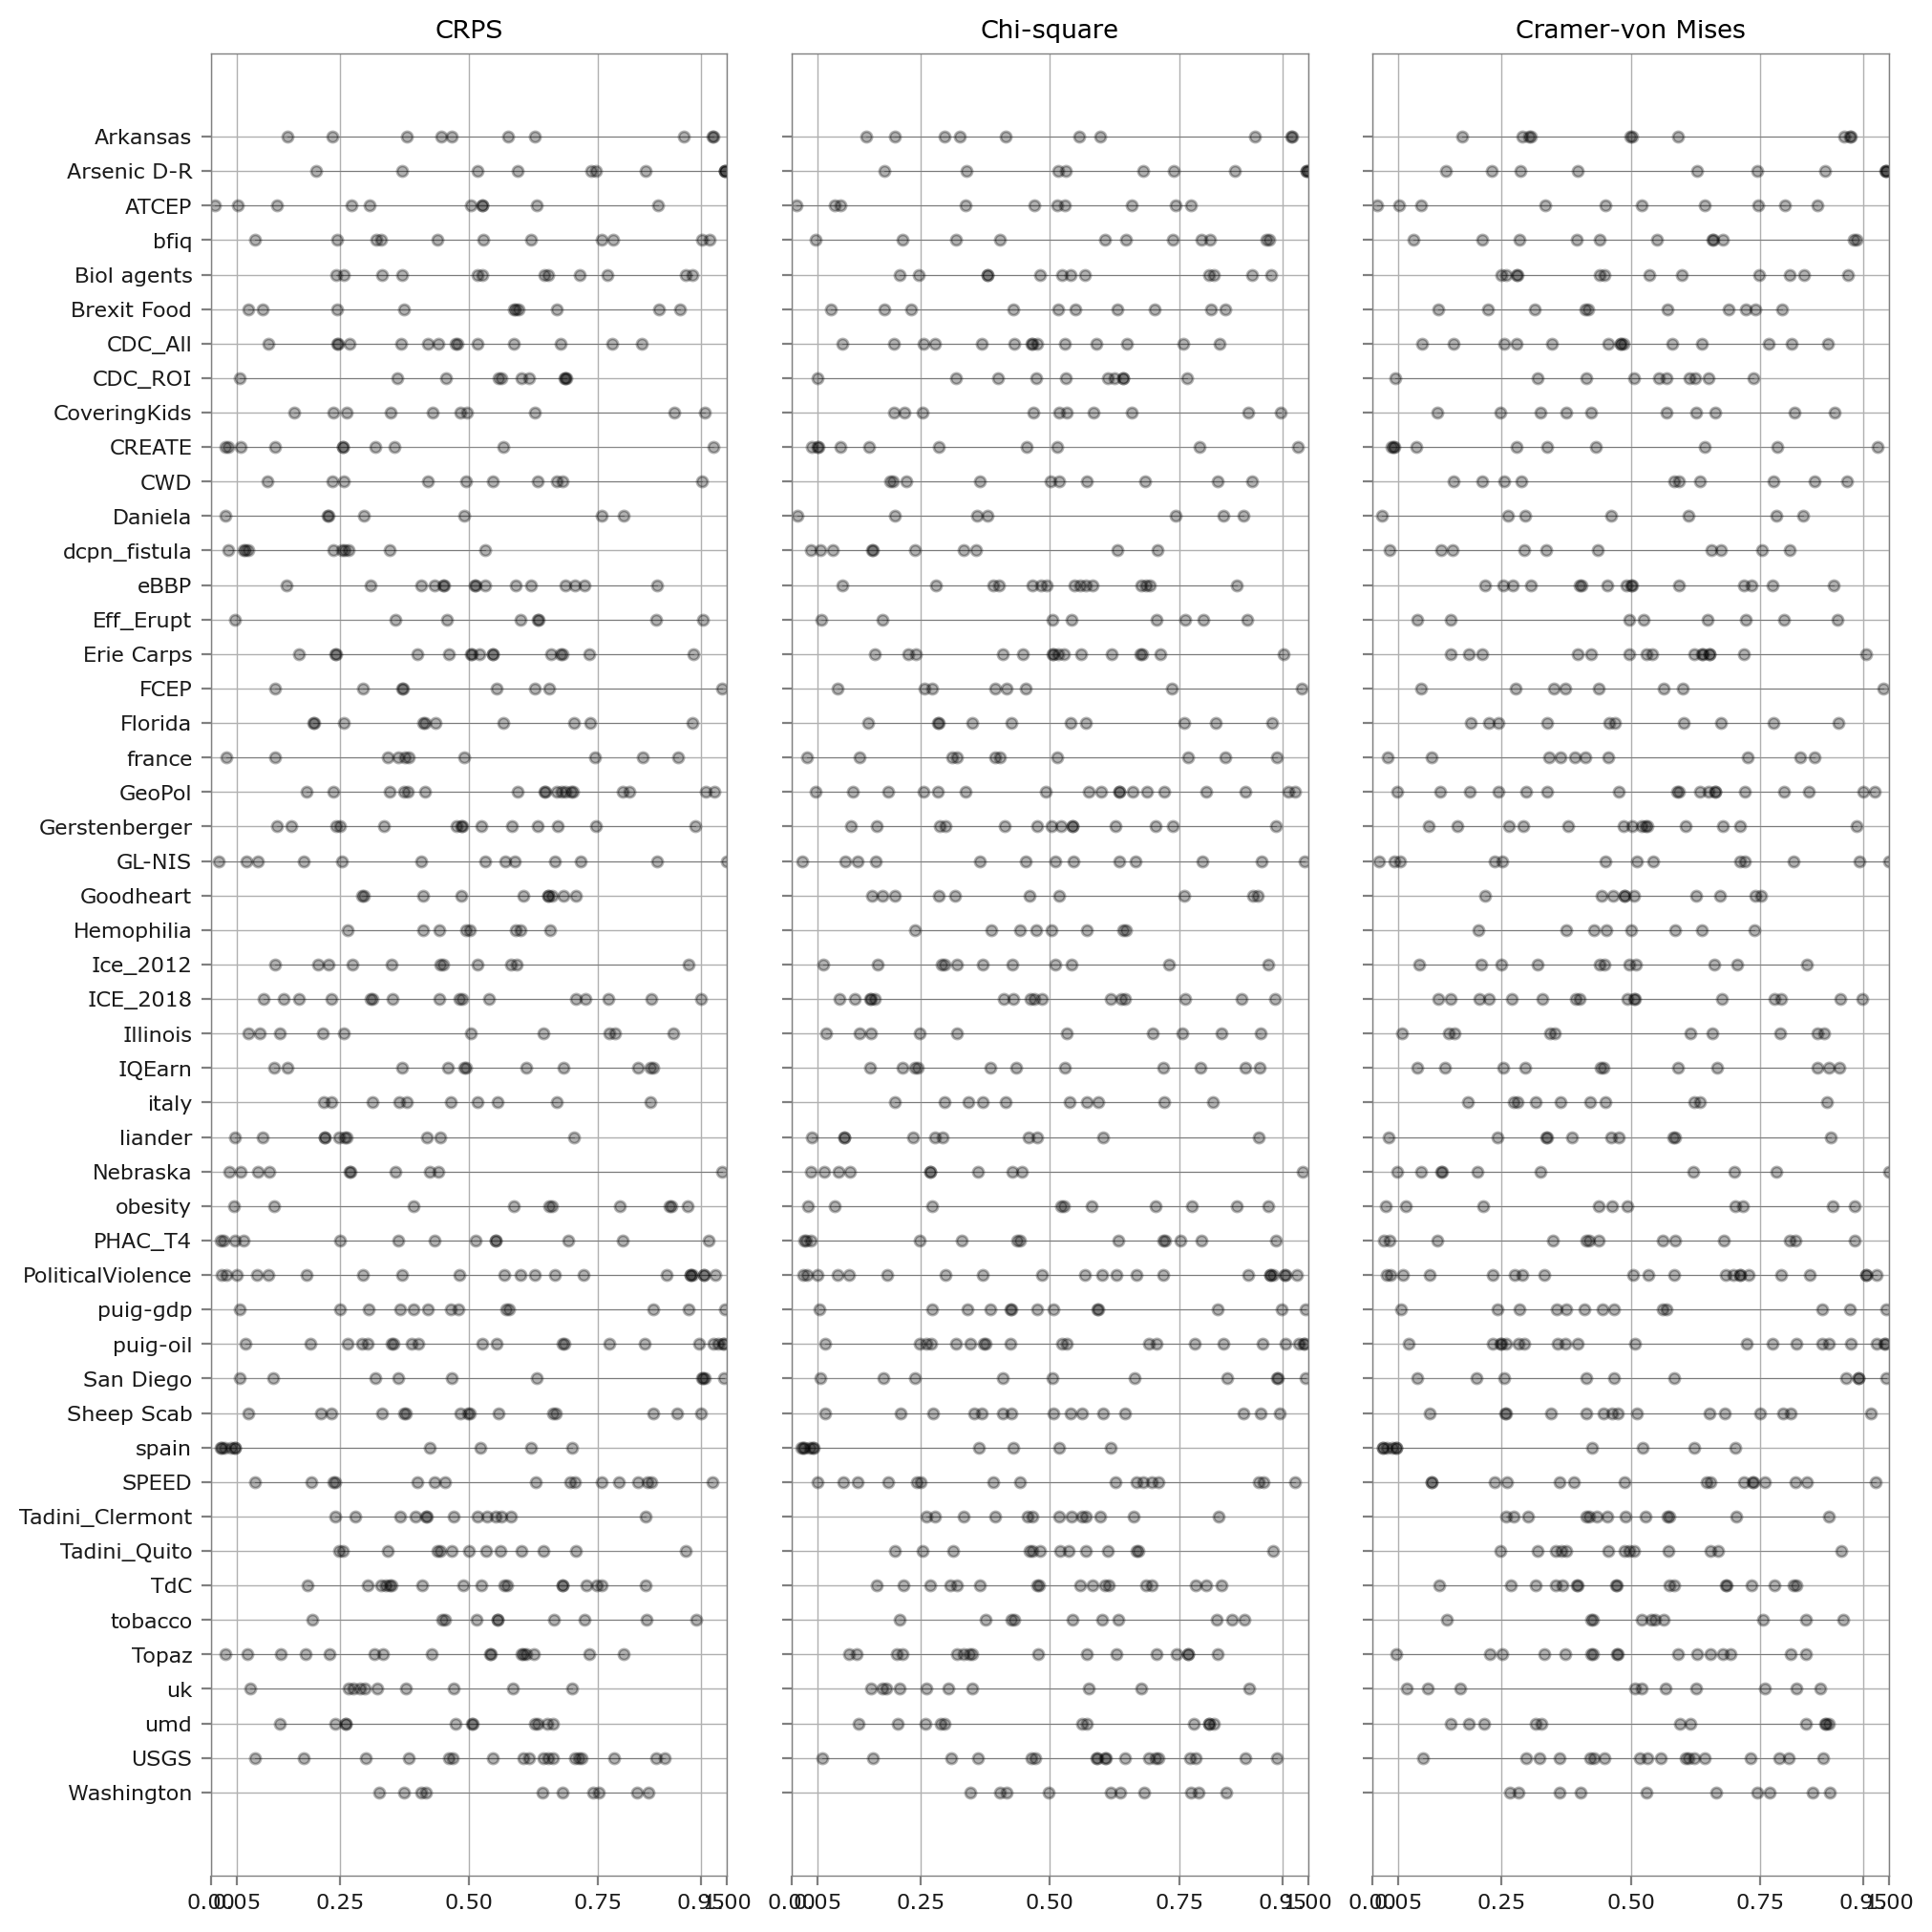

In [8]:
plotting.set_rcparams()

dist = 'PWL'
dm = 'GL'

sa_methods = [CalibrationMethod.CRPS, CalibrationMethod.Chi2, CalibrationMethod.CVM]

fig, axs = plt.subplots(nrows=1, ncols=len(sa_methods), figsize=(10, 10), constrained_layout=True, sharey=True)


scores = {}
for i, (ax, sa_method) in enumerate(zip(axs, sa_methods)):
    for j, case in enumerate(cases):
        ps = np.array(percentiles_dict[case][dist][sa_method.value][dm])
        ax.plot(ps, [-j] * len(ps), marker='o', color='k', ls='-', ms=4, lw=0.25, alpha=0.3)
        quants = quantiles[case]

        scores[(case, sa_method.value)] = {other.value: sa_function[other](ps) for other in sa_methods}
        
    ax.set(title=sa_method.value, xticks=[0, 0.05, 0.25, 0.5, 0.75, 0.95, 1.0], yticks=-np.arange(len(cases)), yticklabels=cases, xlim=(0, 1))
    ax.grid()

    

    

In [189]:
import pandas as pd
df = pd.DataFrame.from_dict(scores, orient='index').unstack().reorder_levels(order=[1, 0], axis=1).sort_index(axis=1)

In [190]:
df.to_excel('tst.xlsx')

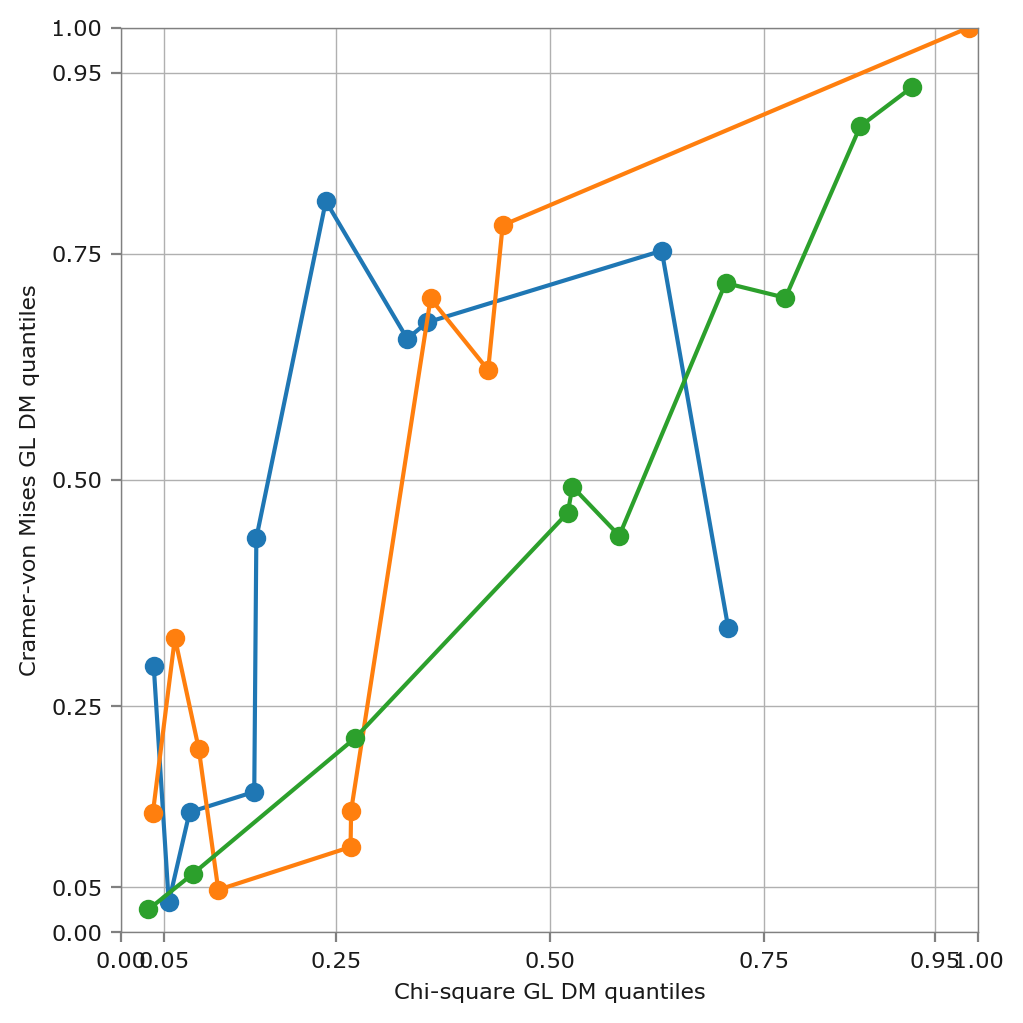

In [175]:
plotting.set_rcparams()

dist = 'PWL'
dm = 'GL'

sa_methods = [CalibrationMethod.Chi2, CalibrationMethod.CVM]

fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
ax.set(xlim=(0, 1), ylim=(0, 1), xlabel=sa_methods[0].value+ f' {dm} DM quantiles', ylabel=sa_methods[1].value+ f' {dm} DM quantiles', 
       xticks=[0, 0.05, 0.25, 0.5, 0.75, 0.95, 1.0], yticks=[0, 0.05, 0.25, 0.5, 0.75, 0.95, 1.0])
ax.grid()

for j, case in enumerate(cases):

    # if case not in ['CDC_ROI', 'GL-NIS', 'puig-gdp']:
        # continue

    if case not in ['Nebraska', 'dcpn_fistula', 'obesity']:
        continue
    x, y = [np.array(percentiles_dict[case][dist][sa_method.value][dm]) for sa_method in sa_methods]
    order = np.argsort(x)

    ax.plot(x[order], y[order], ls='-', marker='o')


    
        
    #     scores[(case, sa_method.value)] = {other.value: sa_function[other](ps) for other in sa_methods}
        
    # ax.set(title=sa_method.value, xticks=[0, 0.05, 0.25, 0.5, 0.75, 0.95, 1.0], yticks=-np.arange(len(cases)), yticklabels=cases, xlim=(0, 1))
    # ax.grid()

    

    

In [186]:
pd.Series({k: len(v) for k, v in quantiles.items()}).to_frame('Nquantiles').sort_index().to_excel('quantiles.xlsx')